# Object Counting on Amazon Bin Image Dataset

## 1. Background

Supply chain management is essential in economics as it allows enterprises to:
1. Achieve better resource monitoring and planning
2. Eliminate redundant transportation costs
3. Satisify customers to give a trace-ability for their delivery

Since [the invention of the Barcode and its patent in 1951](https://en.wikipedia.org/wiki/Barcode), it has been used for inventory managements and still useful as we experience at our daily lives like in-store checkouts. However, reading barcodes printed on the products is time-consuming because we need to find the exact location of the barcodes. At every checkpoint, reading barcodes costs lots of human-labors.

As a technically better solution, the first ancestor of modern [RFID](https://en.wikipedia.org/wiki/Radio-frequency_identification) was patented in 1973. Like [FasTrak](https://www.bayareafastrak.org/) on highways, RFID tags can be read automatically without human-intervention. However, RFID tags are more expensive than the printed barcodes so that they increase the final product cost. In addition, RFID tags have environmental side-effects becuase they are microchips which produces electronic wastes. Due to the limitation, they are often attached manually to the assets during the tracking period and detached to be reused for other assets later.

During the last decade, image classification using machine learning has been significantly improved a lot from `50%` to `90%` in terms of the classification accuracy.

https://paperswithcode.com/sota/image-classification-on-imagenet

![ImageNet](https://github.com/williamhyun/nd009t-capstone-starter/raw/70e67acc83d433ed6945a4d813b77590a0e060d5/starter/ImageNet.png)

The improved vision-based machine learning can disrupt the existing supply chain operating practices by introducing new ways to save costs.

## 2. Problem Statement

Although there exists many published pre-trained models based on `ImageNet`, it is not easy to apply in the real-world problems due to the lack of resources like real-domain data or computing resources. To achieve a reasonably good accuracy within the given project timeline in the real-world environment, we need to narrow down the focus.

Amazon provides a good real-world image data set for object recognition and counting problem. As one of the simplified version of object recognition, this project focuses on `Object Counting` problem on Amazon Bin Image Dataset instead of identifing the objects by reading barcode or RFID.

## 3. Datasets: Amazon Bin Image Dataset

The Amazon Bin Image Dataset contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. This dataset has many images and the corresponding medadata.

### 3.1 Documentation
- https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds

### 3.2 Download
- https://registry.opendata.aws/amazon-bin-imagery/
- https://github.com/awslabs/open-data-registry/blob/main/datasets/amazon-bin-imagery.yaml

### 3.3 License

> Creative Commons Attribution-NonCommercial-ShareAlike 3.0 United States (CC BY-NC-SA 3.0 US) https://creativecommons.org/licenses/by-nc-sa/3.0/us/

### 3.4 Metadata

Metadata files are JSON files containing `image_fname` and `EXPECTED_QUANTITY` fields that can be useful in this counting capstone project.

In [1]:
!aws s3 cp --no-sign-request s3://aft-vbi-pds/metadata/1.json -

{
    "BIN_FCSKU_DATA": {},
    "EXPECTED_QUANTITY": 0,
    "image_fname": "1.jpg"
}

Dataset contains 536,434 **JSON** metadata files.

In [ ]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/metadata/ --summarize > metadatalist

In [55]:
!head -n2 metadatalist

2016-06-21 18:27:38          0 
2017-01-13 15:06:53       2472 00001.json


In [56]:
!tail metadatalist

2017-01-13 17:59:16       4529 99993.json
2017-01-13 17:59:16       4529 99994.json
2017-01-13 17:59:16       3740 99995.json
2017-01-13 17:59:16        864 99996.json
2017-01-13 17:59:16       2132 99997.json
2017-01-13 17:59:16       2770 99998.json
2017-01-13 17:59:16       1658 99999.json

Total Objects: 536435
   Total Size: 1098414519


### 3.5 Data Size

It's useful to check the datasize to get the idea of data processing cost. The dataset has 536,434 **JPEG** files in total in align with metadata files.

In [ ]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/bin-images/ --summarize > list

In [52]:
!head -n2 list

2016-06-17 10:28:56          0 
2017-01-13 14:47:53      45769 00001.jpg


In [53]:
!tail list

2017-01-13 18:03:14      80192 99993.jpg
2017-01-13 18:03:14     104201 99994.jpg
2017-01-13 18:03:14     103665 99995.jpg
2017-01-13 18:03:14      58212 99996.jpg
2017-01-13 18:03:14      39300 99997.jpg
2017-01-13 18:03:14      36076 99998.jpg
2017-01-13 18:03:14      35218 99999.jpg

Total Objects: 536435
   Total Size: 30466377489


### 3.6 File Naming Rules

The dataset considers `1.jpg` and `00001.jpg` differently like the following.

In [2]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/bin-images/1.jpg

2016-06-17 17:30:24      56301 1.jpg


In [3]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/bin-images/00001.jpg

2017-01-13 22:47:53      45769 00001.jpg


In total, it has 536,434 images:
- **1~4 digit**: `1.jpg` ~ `1200.jpg`: 1200
- **5-digit**: `00001.jpg` ~ `99999.jpg`: 99,999
- **6-digit**: `100000.jpg` ~ `535234.jpg`: 435,235

In addtion, in `Udacity Capston preparation chapter`, `Project Overview: Inventory Monitoring at Distribution Centers` provides a selected subset of files, `file_list.json`.

## 4. Exploratory Data Analysis

It's difficult to analyze all 536,434 image data. In this section, I'll focus on the following three.
- `Group 1`: 1200 files with 1~4 digits in their file names
- `Group 2`: 99,999 files with 5 digits in their file names
- `Group 3`: 10,441 flles in the given `file_list.json`

### 4.1 `Group 1` with 1~4 digit in file names

In [26]:
import boto3
from tqdm import tqdm

def download_metadata():
    s3_client = boto3.client('s3')

    directory = 'metadata'
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(1, 1201)):
        file_name = "%s.json" % i
        s3_client.download_file('aft-vbi-pds', os.path.join(directory, file_name), os.path.join(directory, file_name))

download_metadata()

100%|██████████| 1200/1200 [01:27<00:00, 13.72it/s]


In [36]:
import json
import pandas as pd

values = []
directory = "metadata"
for i in range(1, 1201):
    filename = "%s/%s.json" % (directory, i)
    with open(filename, "r") as f:
        data = json.load(f)
        n = data['EXPECTED_QUANTITY']
        values.append(n)

df = pd.DataFrame({'n': values})
df

,n
0,0
1,0
2,0
3,0
4,0
...,...
1195,5
1196,5
1197,5
1198,5


In [37]:
df.describe()

,n
count,1200.000000
mean,2.500000
std,1.708537
min,0.000000
25%,1.000000
50%,2.500000
75%,4.000000
max,5.000000


array([[<AxesSubplot:title={'center':'n'}>]], dtype=object)

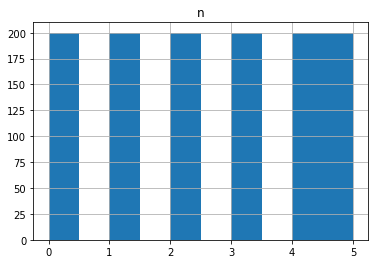

In [38]:
df.hist()

`Group 1` is evenly distributed like a synthetic data.

### 4.2 `Group 2` with 5 digits in file name

In [ ]:
import boto3
from tqdm import tqdm

def download_metadata():
    s3_client = boto3.client('s3')

    directory = 'metadata'
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(1, 100000)):
        file_name = "%05d.json" % i
        s3_client.download_file('aft-vbi-pds', os.path.join(directory, file_name), os.path.join(directory, file_name))

download_metadata()

In [ ]:
import json
import pandas as pd

values = []
directory = "metadata"
for i in range(1, 100000):
    filename = "%s/%05d.json" % (directory, i)
    with open(filename, "r") as f:
        data = json.load(f)
        n = data['EXPECTED_QUANTITY']
        values.append(n)

df = pd.DataFrame({'n': values})
df.to_csv("00001-99999.csv", index=False)

In [25]:
df = pd.read_csv("00001-99999.csv")
df

,n
0,12
1,17
2,16
3,5
4,4
...,...
99994,5
99995,2
99996,16
99997,5


In [26]:
df.describe()

,n
count,99999.000000
mean,5.125321
std,4.758112
min,0.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,209.000000


`95%` data belongs to 0 ~ 12.

In [34]:
df.quantile(.95)

n    12.0
Name: 0.95, dtype: float64

array([[<AxesSubplot:title={'center':'n'}>]], dtype=object)

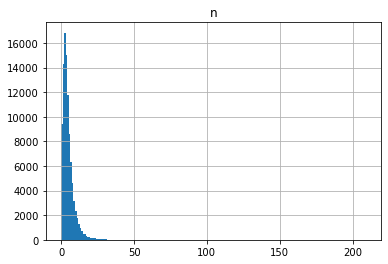

In [29]:
df.hist(bins=200)

### 4.3 `Group 3` with the given file list

In [62]:
import json
with open('file_list.json', 'r') as f:
    d=json.load(f)
for k, v in d.items():
    print("%s has %d items" % (k, len(v)))

1 has 1228 items
2 has 2299 items
3 has 2666 items
4 has 2373 items
5 has 1875 items


In total, `file_list.json` has 10,441 files.

### 4.4 EDA Conclusion
In general, `Group 1` is evenly distributed but the size is too small because it has only 200 images per group. `Group 2` provides more realistic dataset but the distribution is skewed. `Group 3` `file_list.json` has more evenly distributed files. `file_list.json` is a good start to train the baseline model.

## 5. Proposed Solution

I propose to build an object counting service on AWS. The following is the overall architecture.

![Architecture](https://github.com/williamhyun/nd009t-capstone-starter/raw/70e67acc83d433ed6945a4d813b77590a0e060d5/starter/architecture.png)

- **Input**: `Amazon Bin Image Dataset` is used as the training data.
- **Machine Learning**: Transfer learning based on pre-trained CNN Models from the PyTorch library.
- **Training**: SageMaker is used to train PyTorch models from the training data on S3
- **Model**: S3 is used to store the trained model
- **Serving**: Labmda is used to serve the trained model as a service
- **Output**: Service will count object from 0 to 12. According to the EDA result, we are focusing on 95% image data which belongs to 0 ~ 12.



## 6. Benchmark model

PyTorch provides pre-trained models and `ResNet` is `Deep residual networks pre-trained on ImageNet`.

- https://pytorch.org/hub/pytorch_vision_resnet/ (`ResNet18`, `ResNet34`, `ResNet50`, `ResNet101`, `ResNet152`)

### 6.1 Network Architecture

In `Deep residual networks pre-trained on ImageNet`(https://arxiv.org/pdf/1512.03385.pdf), the following network was proposed. The left is a plain network with 34 parameter layers and the right is a residual network with 34 parameter layers.

![ResNet](https://github.com/williamhyun/nd009t-capstone-starter/raw/70e67acc83d433ed6945a4d813b77590a0e060d5/starter/ResNet.png)

During Udacity Capston preparation chapter, `Project Overview: Inventory Monitoring at Distribution Centers`, I built the benchmark model by adding linear fully-connected-layer at the end with the following setting.

In [ ]:
def net():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False   

    num_features=model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_features, 5))
    return model

- Input: 10,441 image files from `file_list.json` are used
- Output: 1 ~ 5
- `ResNet18` as a pre-trained model.
- `ml.m5.xlarge` machine
- `Spot Instance` is used and `63.8%` cost is saved
- `Average accuracy` was `30%`

### 6.2 Data Preparation (Sampling based on `file_list.json`)

#### 6.2.1 Split into train/valid/test sets (8:1:1)

In [75]:
import json
import random

with open('file_list.json', 'r') as f:
    d=json.load(f)

train = {}
valid = {}
test = {}
for k, v in d.items():
    l = len(v)
    print("%s has %d items" % (k, l))
    random.shuffle(v)
    i = (int)(0.8 * l)
    j = (int)(0.9 * l)
    train[k] = v[:i]
    valid[k] = v[i:j]
    test[k] = v[j:]
    print("%s:%s:%s" % (len(train[k]), len(valid[k]), len(test[k])))
    
with open('train.json', 'w') as f:
    json.dump(train, f)
with open('valid.json', 'w') as f:
    json.dump(valid, f)
with open('test.json', 'w') as f:
    json.dump(test, f)

1 has 1228 items
982:123:123
2 has 2299 items
1839:230:230
3 has 2666 items
2132:267:267
4 has 2373 items
1898:237:238
5 has 1875 items
1500:187:188


### 6.2.2 Download and organize data

Downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder.

```
$ tree .
.
├── test
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   └── 5
├── train
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   └── 5
└── valid
    ├── 1
    ├── 2
    ├── 3
    ├── 4
    └── 5
```

In [ ]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data(folder):
    s3_client = boto3.client('s3')

    with open(folder + '.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(folder, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data('train')
download_and_arrange_data('valid')
download_and_arrange_data('test')

In [15]:
!ls -al train valid test

test:
total 52
drwxrwxr-x 7 ec2-user ec2-user  4096 Apr 20 23:58 .
drwxrwxr-x 7 ec2-user ec2-user  4096 Apr 21 05:19 ..
drwxrwxr-x 2 ec2-user ec2-user  4096 Apr 20 23:57 1
drwxrwxr-x 2 ec2-user ec2-user 12288 Apr 20 23:57 2
drwxrwxr-x 2 ec2-user ec2-user 12288 Apr 20 23:57 3
drwxrwxr-x 2 ec2-user ec2-user 12288 Apr 20 23:58 4
drwxrwxr-x 2 ec2-user ec2-user  4096 Apr 20 23:58 5

train:
total 284
drwxrwxr-x 7 ec2-user ec2-user  4096 Apr 21 00:12 .
drwxrwxr-x 7 ec2-user ec2-user  4096 Apr 21 05:19 ..
drwxrwxr-x 2 ec2-user ec2-user 36864 Apr 21 00:04 1
drwxrwxr-x 2 ec2-user ec2-user 65536 Apr 21 00:07 2
drwxrwxr-x 2 ec2-user ec2-user 69632 Apr 21 00:10 3
drwxrwxr-x 2 ec2-user ec2-user 69632 Apr 21 00:12 4
drwxrwxr-x 2 ec2-user ec2-user 40960 Apr 21 00:14 5

valid:
total 52
drwxrwxr-x 7 ec2-user ec2-user  4096 Apr 21 00:02 .
drwxrwxr-x 7 ec2-user ec2-user  4096 Apr 21 05:19 ..
drwxrwxr-x 2 ec2-user ec2-user  4096 Apr 20 23:59 1
drwxrwxr-x 2 ec2-user ec2-user 12288 Apr 20 23:59 2
drwxrwxr-x 

In [16]:
!du -h train valid test

112M	train/4
86M	train/5
53M	train/1
107M	train/2
129M	train/3
485M	train
15M	valid/4
12M	valid/5
6.9M	valid/1
14M	valid/2
17M	valid/3
62M	valid
14M	test/4
12M	test/5
6.3M	test/1
14M	test/2
16M	test/3
61M	test


### 6.2.3 Upload to S3 for training

In [2]:
!aws s3 sync train s3://amazonbin/train

In [3]:
!aws s3 sync valid s3://amazonbin/valid

In [ ]:
!aws s3 sync test s3://amazonbin/test

## 6.3 Train the benchmark model

### 6.3.1 `train.py`

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import os
import sys
import logging
import argparse
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import smdebug.pytorch as smd

logger=logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def test(model, test_loader, hook):
    model.eval()
    running_corrects=0
    for (inputs, labels) in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
    total_acc = running_corrects / len(test_loader.dataset)
    logger.info(f"Test set: Average accuracy: {100*total_acc}%")
    

def train(model, train_loader, valid_loader, epochs, criterion, optimizer, hook):
    count = 0
    for e in range(epochs):
        print(e)
        model.train()
        # hook.set_mode(smd.modes.TRAIN)
        for (inputs, labels) in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            count += len(inputs)

        # validation
        model.eval()
        # hook.set_mode(smd.modes.EVAL)
        running_corrects=0
        with torch.no_grad():
            for (inputs, labels) in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data).item()
        total_acc = running_corrects / len(valid_loader.dataset)
        logger.info(f"Valid set: Average accuracy: {100*total_acc}%")
        
    return model

def net():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False   

    num_features=model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_features, 5))
    return model

def create_data_loaders(data, batch_size, test_batch_size):
    train_data_path = os.path.join(data, 'train')
    test_data_path = os.path.join(data, 'test')
    validation_data_path = os.path.join(data, 'valid')

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        ])
    
    trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transform)
    validset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=test_transform)
    testset = torchvision.datasets.ImageFolder(root=test_data_path, transform=test_transform)
    
    return (
        torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True),
        torch.utils.data.DataLoader(validset, batch_size=test_batch_size, shuffle=False),
        torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False))

def main(args):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    logging.info(f"Running on Device {device}")

    model=net()
    model=model.to(device)
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=args.lr)
    
    # hook = smd.Hook.create_from_json_file()
    # hook.register_hook(model)
    hook = None

    train_loader, valid_loader, test_loader = create_data_loaders(args.data, args.batch_size, args.test_batch_size)
    
    model=train(model, train_loader, valid_loader, args.epochs, loss_criterion, optimizer, hook)
    
    # test(model, test_loader, hook)
    
    torch.save(model.cpu().state_dict(), os.path.join(args.model_dir, "model.pth"))

if __name__=='__main__':
    parser=argparse.ArgumentParser()

    parser.add_argument(
        "--batch-size",
        type=int,
        default=32,
        metavar="N",
        help="input batch size for training (default: 256)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=32,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=2,
        metavar="N",
        help="number of epochs to train (default: 2)",
    )
    parser.add_argument(
        "--lr", type=float, default=0.001, metavar="LR", help="learning rate (default: 0.001)"
    )
    parser.add_argument(
        "--momentum", type=float, default=0.5, metavar="M", help="SGD momentum (default: 0.5)"
    )
    parser.add_argument('--data', type=str, default=os.environ["SM_CHANNEL_TRAIN"])
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    
    args=parser.parse_args()
    
    logging.info(f"Learning Rate: {args.lr}")
    logging.info(f"Momentum: {args.momentum}")
    logging.info(f"Batch Size: {args.batch_size}")
    logging.info(f"Test Batch Size: {args.test_batch_size}")
    logging.info(f"Epochs: {args.epochs}")
    
    main(args)

### 6.3.2 Train Benchmark Model

In [11]:
import sagemaker
import boto3
import os

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "amazonbin"
role = sagemaker.get_execution_role()

In [12]:
from sagemaker.pytorch import PyTorch
import os

estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    use_spot_instances=True,
    max_run=3600,
    max_wait=3600,
)

In [13]:
estimator.fit({'train': 's3://amazonbin/'})

2022-04-21 04:52:50 Starting - Starting the training job...
2022-04-21 04:52:52 Starting - Launching requested ML instancesProfilerReport-1650516770: InProgress
.........
2022-04-21 04:54:43 Starting - Preparing the instances for training.........
2022-04-21 04:56:03 Downloading - Downloading input data...........................
2022-04-21 05:00:50 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-21 05:01:04,214 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-21 05:01:04,216 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-04-21 05:01:04,225 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-21 05:01:07,267 sagemaker_pytorch_container.training INFO     Invoking user training script.

2022-04-21 05:01:05 Training - Training image download c

## 7. Evaluation metrics

`Accuracy` is the evaluation metrics for both benchmark model and solution model.

1. For comparision, 10% of images whose item count is between 0 and 5 will be selected as the final answer set.
The benchmark model and the proposed model will be tested with that same answer set in the end.

2. To measure new solution model, another 10% of images whose item count is beteen 0 and 12 will be selected as the second final answer set.
The proposed model will be tested with that answer set in the end.

## 8. Project Design Outline

This project is already using Spot Instance to minimize the exploration cost. Given the cost saving, I will proceed the following in the order.

1. First of all, use more input data to train
2. Second, hyperparameter tuning.
3. Thrid, consider other pre-trained CNN models like `EfficientNet`, `ResNet50`, `VGG19`, `Inceptionv3 (GoogLeNet)`

### 8.1 EfficientNet

`EfficientNet-B1` is known to be 7.6x smaller and 5.7x faster than than `ResNet-152`.
However, we cannot use in SageMaker.
```
AttributeError: module 'torchvision.models' has no attribute 'efficientnet_b0'
```

https://arxiv.org/pdf/1905.11946v5.pdf

In [ ]:
import sagemaker
import boto3
import os

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "amazonbin"
role = sagemaker.get_execution_role()

from sagemaker.pytorch import PyTorch
import os

estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py38',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    use_spot_instances=True,
    max_run=3600,
    max_wait=3600,
)

estimator.fit({'train': 's3://amazonbin/'})